<a href="https://colab.research.google.com/github/knwin/generic/blob/master/Train_palm_tree_detection_SSD_training_with_arcgis_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting palm trees on UAV imagery

This notebook is adopted from SSD model training part from https://learn.arcgis.com/en/projects/use-deep-learning-to-assess-palm-tree-health/

However training will be carried out on the Colab to take advantage of GPU.

Packages in *install-deep-learning-frameworks-manually-2-7-_2.pdf* are used.

Issues: at this moment the model trained on Colab gets error when used on ArcGIS Pro. 
Therefore prediction is tested on Colab. No padding is used in the prediction code. A solution to remove overlapping bboxes is not implemented. aspect ratio and area information can be used to filter bad prediction at later stage.

Result is a csv file with c*lass name, probability,center coordinates, width, height, aspect_ration, and area* information of each objeect detected.

Note: yolov3 has better detection than SSD in my tests.

Written by Kyaw Naing Win, GIS Manager, CDE.

Last update: 21 May 2021

## SETUP

In order to use arcgis module, it is better to use the modules recommended by ESRI. 

In [ ]:
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
# INSTALL ESRI recommended pacakges
# from esri -   install-deep-learning-frameworks-manually-2-7-_2.pdf
!conda install -c esri -c fastai -c pytorch arcgis=1.8.1 absl-py=0.11.0 aiohttp=3.6.3 ase=3.19.1 astor=0.8.1 async-timeout=3.0.1 beautifulsoup4=4.9.3 cachetools=4.1.1 catalogue=1.0.0 cloudpickle=1.6.0 cudatoolkit=10.1.243 cudnn=7.6.5 cymem=2.0.4 cython=0.29.21 cython-blis=0.4.1 cytoolz=0.11.0 dask-core=2.30.0 fastai=1.0.60 fastprogress=0.2.3 fasttext=0.9.2 filelock=3.0.12 gast=0.2.2 google-auth=1.23.0 google-auth-oauthlib=0.4.2 google-pasta=0.2.0 googledrivedownloader=0.4 grpcio=1.31.0 imageio=2.8.0 isodate=0.6.0 joblib=0.17.0 keepalive=0.5 keras-applications=1.0.8 keras-base=2.3.1 keras-gpu=2.3.1 keras-preprocessing=1.1.0 laspy=1.7.0 libprotobuf=3.13.0.1 libwebp=1.1.0 llvmlite=0.34.0 markdown=3.3.3 multidict=4.7.6 murmurhash=1.0.2 ninja=1.10.1 numba=0.51.2 nvidia-ml-py3=7.352.0 onnx=1.7.0 onnx-tf=1.5.0 opt_einsum=3.1.0 plac=1.1.0 plotly=4.5.4 preshed=3.0.2 protobuf=3.13.0.1 pyasn1=0.4.8 pyasn1-modules=0.2.8 pytorch=1.4.0 pywavelets=1.1.1 rdflib=5.0.0 retrying=1.3.3 rsa=4.6 sacremoses=0.0.43 scikit-image=0.17.2 scikit-learn=0.23.2 sentencepiece=0.1.91 soupsieve=2.0.1 spacy=2.2.4 sparqlwrapper=1.8.5 srsly=1.0.2 tensorboard=2.3.0 tensorboard-plugin-wit=1.6.0 tensorboardx=2.1 tensorflow=2.1.0 tensorflow-addons=0.9.1 tensorflow-base=2.1.0 tensorflow-estimator=2.1.0 tensorflow-gpu=2.1.0 termcolor=1.1.0 thinc=7.4.0 threadpoolctl=2.1.0 tifffile=2020.10.1 tokenizers=0.8.1 toolz=0.11.1 torch-cluster=1.5.4 torch-geometric=1.5.0 torch-scatter=2.0.4 torch-sparse=0.6.1 torch-spline-conv=1.2.0 torchvision=0.5.0 tqdm=4.51.0 transformers=3.3.0 typeguard=2.7.0 wasabi=0.6.0 werkzeug=0.16.1 yarl=1.6.2
!conda install https://anaconda.org/conda-forge/py-opencv/4.5.0/download/linux-aarch64/py-opencv-4.5.0-py37hc16ab0a_7.tar.bz2 
!conda install https://anaconda.org/conda-forge/libopencv/4.5.0/download/linux-aarch64/libopencv-4.5.0-py37h1260bc3_7.tar.bz2
!conda install https://anaconda.org/conda-forge/graphviz/2.38.0/download/linux-64/graphviz-2.38.0-hf68f40c_1011.tar.bz2
!pip install pooch==1.0.0

### Get image chips for training and image to test
Image chips are from UAV image used in the above training link and primarily prepared on ArcGIS pro and later refined on Image Labeller.

In [ ]:
! pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

#download image chips
gdd.download_file_from_google_drive(file_id='13N2flick5ls4COWD3VAkRjyyk-U_spQo',
                                    dest_path='./palmtree_images/images.zip',
                                    unzip=True)

#download UAV image
gdd.download_file_from_google_drive(file_id='107Td2m0vjKP1FYPq9fpnEL4UJi0RNIJC',
                                    dest_path='./palmtree_images/Kolovai UAV4R Subset.tif',
                                    unzip=False)

#download smaller (subset) image for quick test
gdd.download_file_from_google_drive(file_id='10ulqjZElhz3e5QNICi-LFHH9twxkP3vZ',
                                    dest_path='./palmtree_images/subset_test.jpg',
                                    unzip=False)

#download esri files created with image chips
gdd.download_file_from_google_drive(file_id='1F8z4ve_j-er41RglG6b1bfKBjh-MK_QC',
                                    dest_path='./palmtree_images/esri_statfiles.zip',
                                    unzip=True)

Unzipping...Done.


## Prepare Data

https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#prepare-data

 arcgis.learn.prepare_data(path, class_mapping=None, chip_size=224, val_split_pct=0.1, batch_size=64, transforms=None, collate_fn=<function _bb_pad_collate>, seed=42, dataset_type=None, resize_to=None, **kwargs)

In [ ]:
from arcgis.learn import prepare_data

data = prepare_data('./palmtree_images',
                    class_mapping={1: 'Palm'},
                    chip_size=448,
                    val_split_pct = 0.1,
                    batch_size=8 )


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


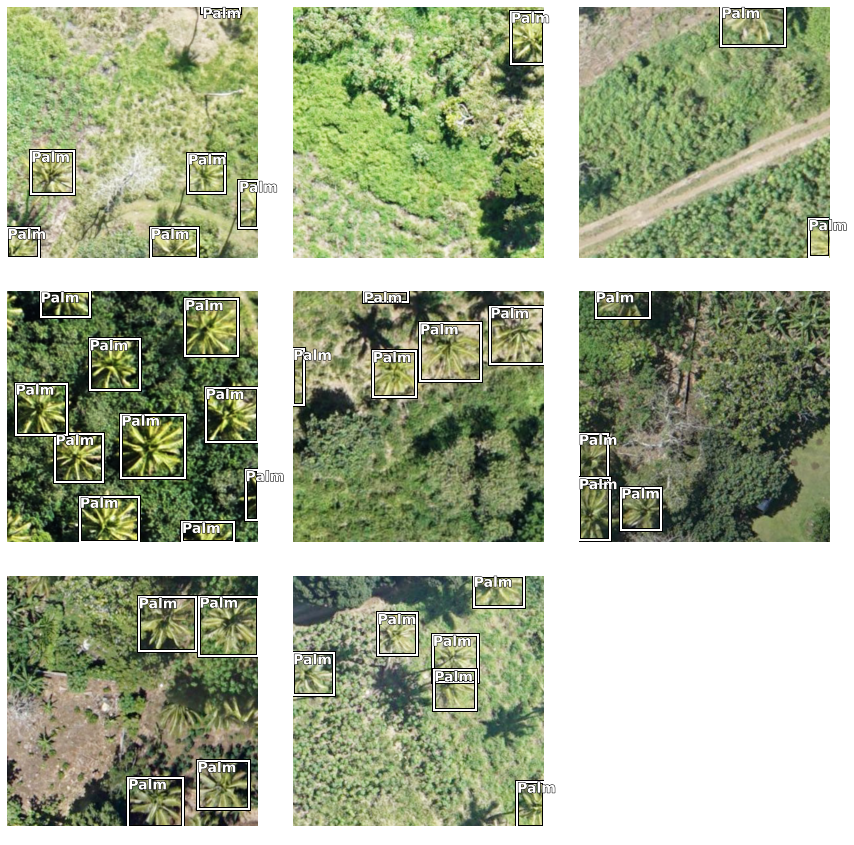

In [ ]:
data.show_batch(rows=5) # repeat to see different batch of training images

## Train SSD Model

In [ ]:
from arcgis.learn import SingleShotDetector

In [ ]:
ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


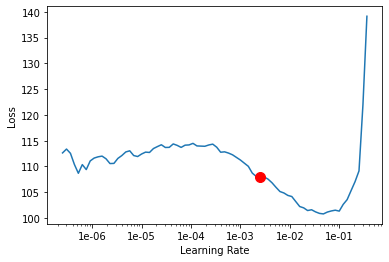

In [ ]:
# find efficient learning rate to use in the training. 
# But if lr is not provided, arcgis-learn will use optimal one
lr0=ssd.lr_find()

In [ ]:
lr0

0.002511886431509582

In [ ]:
# start trining
ssd.fit(epochs=200, early_stopping=True,lr=slice(lr0/10,lr0))
# without lr value, it will find optimum learning rates, early stopping will stop the program at optium epoch

epoch,train_loss,valid_loss,time
0,100.480789,80.820938,00:09
1,89.133011,76.522964,00:09
2,84.264793,72.974136,00:09
3,80.258133,71.449829,00:09
4,76.451927,69.211777,00:09
5,72.256447,66.296127,00:09
6,69.167290,62.535694,00:09
7,67.887039,61.040539,00:09
8,66.804451,61.871731,00:09
9,65.691933,56.394718,00:09


Epoch 59: early stopping


precision %:  68.72803200515214


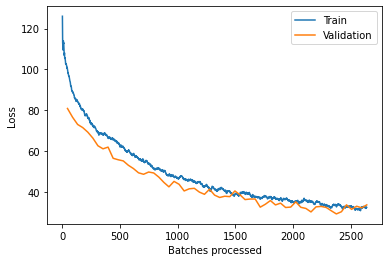

In [ ]:
prec = ssd.average_precision_score().get('Palm')*100
print ("precision %: ", prec)
ssd.plot_losses()


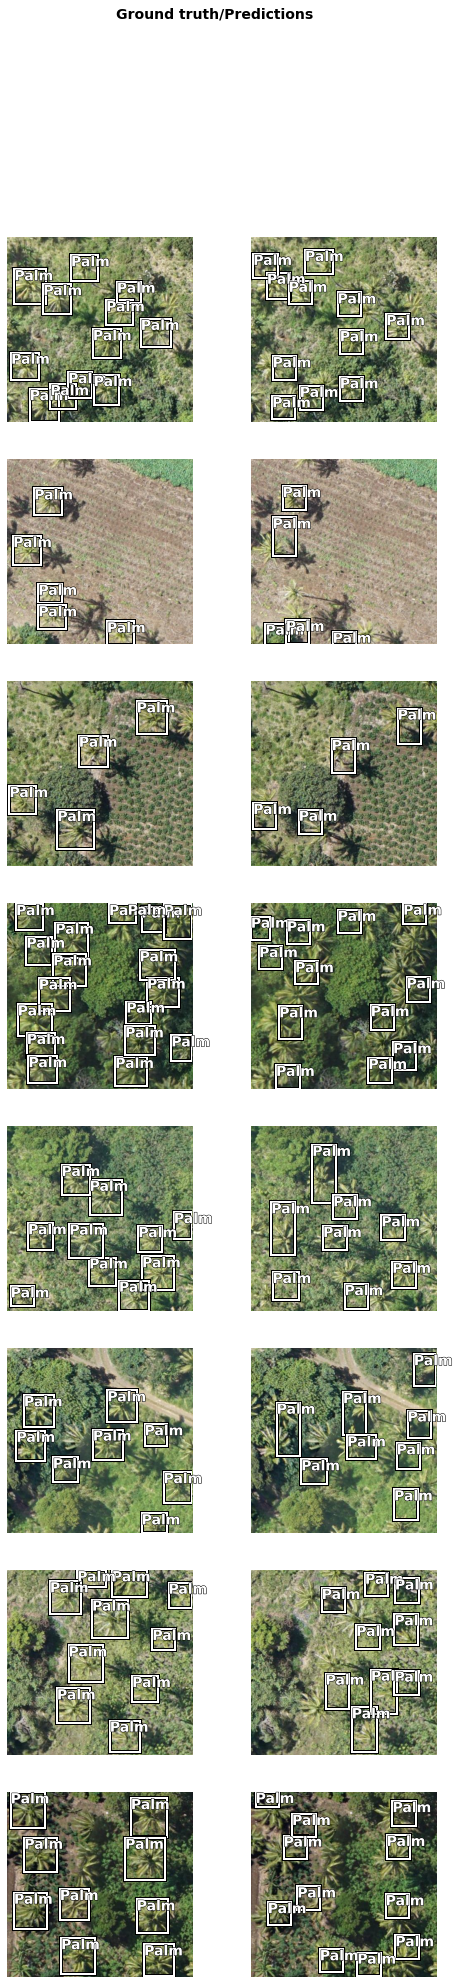

In [ ]:
# view results
ssd.show_results(rows=10, thresh=0.35)

In [ ]:
ssd.unfreeze() #update the weights in pretrained mode
# save the trained model
model_name = f'palmtree_detector_ssd_{prec:.0f}pc'
ssd.save(model_name)
print (model_name,' has been saved')

palmtree_detector_ssd_69pc  has been saved


# Prediction test on small image

SSD does not work on large image outside of ArcGISPro. Therefore It needs to be tiled at smaller size (800 x 800 example)

In [ ]:
from arcgis.learn import SingleShotDetector
from arcgis.learn import prepare_data

data = prepare_data('./palmtree_images',
                    class_mapping={1: 'Palm'},
                    chip_size=448,
                    val_split_pct = 0.1,
                    batch_size=2 )

ssd = SingleShotDetector(data,grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])


In [ ]:
ssd.load(model_name)

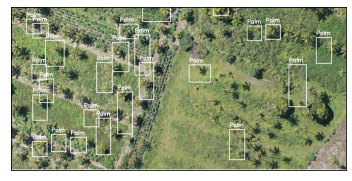

In [ ]:
# subset of large aerial imagery 800 x 600 image
source_img = './palmtree_images/subset_test.jpg'

# ssd.predict(image_path, threshold=0.5, nms_overlap=0.1, return_scores=False, visualize=False, resize=False)
predictions = ssd.predict(source_img,threshold=0.3,nms_overlap=0.2,return_scores=True,visualize=True)

### Prediction on large image (satellite/uav)
Since SSD does not work on large image, it is necessary to split the image to smaller tiles and detection is done on the tile images.

In [ ]:
from osgeo import gdal
import numpy as np
from PIL import Image

In [ ]:
def pixelToMap( pX, pY, geoTransform ):
	'''Convert pixel coordinates to map coordinates.'''
	mX, mY = applyGeoTransform( pX, pY, geoTransform )
	return mX, mY
def applyGeoTransform( inX, inY, geoTransform ):
	'''Apply a geotransform to coordinates.'''
	outX = geoTransform[ 0 ] + inX * geoTransform[ 1 ] + inY * geoTransform[ 2 ]
	outY = geoTransform[ 3 ] + inX * geoTransform[ 4 ] + inY * geoTransform[ 5 ]
	return outX, outY

In [ ]:
source_image = r"./palmtree_images/Kolovai UAV4R Subset.tif"


In [ ]:
image = gdal.Open(source_image)
gt = image.GetGeoTransform()
image_np_array = np.moveaxis(np.array(image.ReadAsArray()),0,-1) # layer index moved to end

In [ ]:
image_np_array = image_np_array[:,:18400,:]

In [ ]:
# parameters for making chips on which detection will be made
h,w,b = image_np_array.shape
chip_h = 500
chip_w = 400
rows = np.arange (0,h,chip_h)
cols = np.arange (0,w,chip_w)

In [ ]:
# detect objects
import datetime

#csv_name = os.path.join(os.path.dirname(source_image), "detection_report.csv")
csv_name = "detection_report.csv"
print ("detection started:", datetime.datetime.now(),"\n")
obj_count = 0
with open(csv_name, 'w') as f:
    f.write("object,probability,lon,lat,width,height,aspect_ratio,area\n")
    for row in rows:
        for col in cols:
            image_chip = image_np_array[row:(row+chip_h), col:(col+chip_w), :]
            #image_chip = Image.fromarray(image_chip)
            detections = ssd.predict(image_chip,threshold=0.3,nms_overlap=0.2,return_scores=True,visualize=False)
            #detections = detector.detectObjectsFromImage(input_image=image_chip, input_type ="array", output_image_path=image_detected, minimum_percentage_probability=30)
            offsetX = col
            offsetY = row
            
            for i in range(len(detections[0])):            
                
                detected_class = detections[1][i]
                prob = detections[2][i]

                cenX, cenY, w, h = detections[0][i] #bbox parameters
                imgX = cenX + offsetX
                imgY = cenY + offsetY
                X,Y = pixelToMap(imgX,imgY,gt)
                w = w * gt[1] # convert to map unit
                h = abs(h * gt[5]) # convert to map unit
                aspect = w / h
                area = w * h
                #print (detection["name"], ",", detection["percentage_probability"], ",",X,",",Y)
                data = detected_class + "," + str(prob) + "," + str(X) + "," + str(Y) + "," + str(w)+ "," +str(h)+ "," +str(aspect) +","+str(area)+ "\n"
                f.write(data)
            obj_count += len(detections[0])
            
            print("\rnumber of object detected: ", obj_count,end="",flush=True)
           
print ("\n\ndetection completed: ",datetime.datetime.now(),"\ndetection results are saved in", csv_name)

detection started: 2021-05-22 11:11:09.898838 

number of object detected:  4347number of object detected:  4347
detection completed:  2021-05-22 11:15:17.314959 
detection results are saved in detection_report.csv
